In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
from cliff_jax import Cliff

In [30]:
env = Cliff.full()

In [33]:
env.step(Cliff.InternalState(16, 0), 0)

(InternalState(state=Array(8, dtype=int32), step=Array(1, dtype=int32, weak_type=True)),
 Array(-1, dtype=int32, weak_type=True),
 Array(False, dtype=bool))

In [34]:
internal_state = env.reset()
env.observe(internal_state)

Array(16, dtype=int32)

In [35]:
env.step(internal_state, 1)

(InternalState(state=Array(16, dtype=int32), step=Array(1, dtype=int32, weak_type=True)),
 Array(-1, dtype=int32, weak_type=True),
 Array(False, dtype=bool))

In [36]:
import typing
import jax, jax.numpy as jnp, jax.random as jr
key = jr.key(0)

class Embedding(typing.NamedTuple):
  num_emb: int
  emb_dim: int

  def __call__(self, params, _key, x):
    return params[x]
  
  def logp(self, params, x, y):
    logits = self(params, ..., x)
    return jax.nn.log_softmax(logits)[y]

  def init(self, key):
    return jr.normal(key, (self.num_emb, self.emb_dim))

In [37]:
class EpsGreedy(typing.NamedTuple):
  model: typing.Any
  num_actions: int
  eps: float = .1

  def __call__(self, params, key, *args):
    key, eps_key = jr.split(key)
    # use cond to run the model only when it's necessary
    return jax.lax.cond(
      jr.uniform(eps_key) >= self.eps,
      # take model's prediction (greedy)
      lambda: self.model(params, key, *args).argmax(axis=-1),
      # select a random action
      lambda: jr.choice(key, self.num_actions),
    )
  
  def logp(self, params, x, y):
    return jnp.log(self.eps / self.num_actions + (1 - self.eps) * jnp.exp(self.model.logp(params, x, y)))

  def init(self, key):
    return self.model.init(key)

In [38]:
class Buf(typing.NamedTuple):
  max_num_eps: int
  max_episode_len: int

  class State(typing.NamedTuple):
    offset: jax.Array # int, current location in the buffer
    num_eps: jax.Array # int, number of episodes that is contained in this buffer
    ep_ends: jax.Array # end markers for episodes in the buffer (exclusive)
    observations: typing.Any
    actions: typing.Any
    rewards: typing.Any

    @property
    def ep_starts(self) -> jax.Array:
      starts = jnp.zeros_like(self.ep_ends)
      return starts.at[1:].set(self.ep_ends[:-1])
    
    @property
    def buf_size(self) -> int:
      return len(self.observations)

    def reset(self) -> "Buf.State":
      return Buf.State(
        offset=jnp.asarray(0),
        num_eps=jnp.asarray(0),
        ep_ends=self.ep_ends,
        observations=self.observations,
        actions=self.actions,
        rewards=self.rewards,
      )
  
  def can_append_episode(self, state: "State") -> bool:
    free = state.buf_size - state.offset
    return (state.num_eps < self.max_num_eps) & (free >= self.max_episode_len)

  def append(self, state: "State", obs, action, reward) -> "State":
    newoffset = state.offset + 1
    in_bounds = newoffset < len(state.observations)
    return Buf.State(
      offset=jnp.where(in_bounds, newoffset, state.offset),
      num_eps=state.num_eps,
      ep_ends=state.ep_ends,
      observations=jnp.where(in_bounds, state.observations.at[state.offset].set(obs), state.observations),
      actions=jnp.where(in_bounds, state.actions.at[state.offset].set(action), state.actions),
      rewards=jnp.where(in_bounds, state.rewards.at[state.offset].set(reward), state.rewards),
    )

  def end_episode(self, state: "State") -> "State":
    # Safety: calling can_append_episode before appending/ending an episode ensures that there is enough space
    return Buf.State(
      offset=state.offset,
      num_eps=state.num_eps + 1,
      ep_ends=state.ep_ends.at[state.num_eps].set(state.offset),
      observations=state.observations,
      actions=state.actions,
      rewards=state.rewards,
    )
  
  def empty(self, buf_size: typing.Optional[int] = None) -> "State":
    if buf_size is None:
      buf_size = self.max_num_eps * self.max_episode_len
    return Buf.State(
      offset=jnp.asarray(0),
      num_eps=jnp.asarray(0),
      ep_ends=jnp.zeros(self.max_num_eps, dtype=int),
      observations=jnp.zeros(buf_size, dtype=int),
      actions=jnp.zeros(buf_size, dtype=int),
      rewards=jnp.zeros(buf_size),
    )

In [39]:
action_tab = Embedding(24, 4)
eps_greedy = EpsGreedy(action_tab, 4)

In [40]:
def run_episode(key, params, buf: Buf, buf_state: Buf.State, env: Cliff) -> Buf.State:
  "Run one episode of `env` and store the results in `buf`/`buf_state`."
  model = eps_greedy # TODO: pass this into the function

  class LoopState(typing.NamedTuple):
    key: jax.Array
    env_state: Cliff.InternalState
    buf_state: Buf.State
    done: jax.Array # bool

  def cond(state: LoopState):
    return ~state.done
  
  def body(state: LoopState):
    obs = env.observe(state.env_state)
    key, action_key = jr.split(state.key)
    action = model(params, action_key, obs)
    env_state, reward, done = env.step(state.env_state, action)
    buf_state = buf.append(state.buf_state, obs, action, reward)
    return LoopState(
      key=key,
      env_state=env_state,
      buf_state=buf_state,
      done=done,
    )

  state = LoopState(
    key=key,
    env_state=env.reset(),
    buf_state=buf_state,
    done=jnp.asarray(False),
  )
  state = jax.lax.while_loop(cond, body, state)
  buf_state = buf.end_episode(state.buf_state) # finalize episode
  return buf_state

@jax.jit
def fill_buffer(key, params, buf: Buf, buf_state: Buf.State, env: Cliff) -> Buf.State:
  "Run episodes until `buf`/`buf_state` cannot store another episode."
  class LoopState(typing.NamedTuple):
    key: jax.Array
    buf_state: Buf.State

  def cond(state: LoopState):
    return buf.can_append_episode(state.buf_state)
  
  def body(state: LoopState):
    key, run_key = jr.split(state.key)
    buf_state = run_episode(run_key, params, buf, state.buf_state, env)
    return LoopState(key, buf_state)

  state = LoopState(key, buf_state)
  state = jax.lax.while_loop(cond, body, state)
  return state.buf_state

In [41]:
def reduce_episodes(fn, carry_init, buf_state: Buf.State):
  class LoopState(typing.NamedTuple):
    carry: typing.Any
    epidx: jax.Array # int

  def body(offset: int, state: LoopState):
    not_done = offset < buf_state.offset # buf's current level is not reached yet
    next_offset_overflow = (offset + 1) >= buf_state.ep_ends[state.epidx] # increase eps idx preventive
    return LoopState(
      carry=jnp.where(not_done, fn(buf_state, state.epidx, offset, state.carry), state.carry),
      epidx=jnp.where(not_done & next_offset_overflow, state.epidx + 1, state.epidx)
    )
  
  state = LoopState(carry_init, jnp.asarray(0))
  state = jax.lax.fori_loop(0, buf_state.buf_size, body, state)
  return state.carry

In [58]:
# compute sum of rewards for each episode
def accumulate_rewards(buf_state, ep_idx, offset, ep_rew):
  reward = buf_state.rewards[offset]
  return ep_rew.at[ep_idx].set(ep_rew[ep_idx] + reward)

def get_episode_reward(buf: Buf, buf_state: Buf.State):
  "Returns cumulative reward for each episode"
  return reduce_episodes(accumulate_rewards, jnp.zeros(buf.max_num_eps), buf_state)

import functools
@functools.partial(jax.jit, static_argnames="buf")
def expected_reward(params, buf: Buf, buf_state: Buf.State) -> jax.Array:
  model = eps_greedy # TODO: pass this into the function

  # compute sum of logps for each episode
  def accumulate_logps(buf_state: Buf.State, ep_idx, offset, logps):
    obs, act = buf_state.observations[offset], buf_state.actions[offset]
    logp = model.logp(params, obs, act) # compute \pi(s_t\vert a_t)
    return logps.at[ep_idx].set(logps[ep_idx] + logp)
    
  weights = get_episode_reward(buf, buf_state)
  logps = reduce_episodes(accumulate_logps, jnp.zeros(buf.max_num_eps), buf_state)
  # weight logps and compute average to approximate E[J(\pi)] over all episodes
  return jnp.sum(weights * logps) / buf_state.num_eps

In [70]:
# initialize model parameters
key, model_key = jr.split(key)
params_init = eps_greedy.init(model_key)
params = params_init

# create trajectory buffer
buf = Buf(20, env.max_steps)
buf_state = buf.empty(buf_size=200)

In [71]:
from tqdm import trange
for _ in (pbar := trange(5000)):
    # generate trajectories
    buf_state = buf_state.reset() # reset buffer instead of always reallocating
    key, ep_key = jr.split(key)
    buf_state = fill_buffer(ep_key, params, buf, buf_state, env)

    # compute gradients and update model using gradient ascent
    expected_reward_val, grads = jax.value_and_grad(expected_reward)(params, buf, buf_state)
    params = jax.tree_util.tree_map(lambda p, g: p + 1e-3 * g, params, grads)

    # bookkeeping
    num_eps = buf_state.num_eps.item()
    pbar.set_description(f"{num_eps=:4d} erew={expected_reward_val.item():7.02f}")

  0%|          | 0/5000 [00:00<?, ?it/s]

num_eps=  15 erew=-164.02: 100%|██████████| 5000/5000 [01:39<00:00, 50.11it/s]


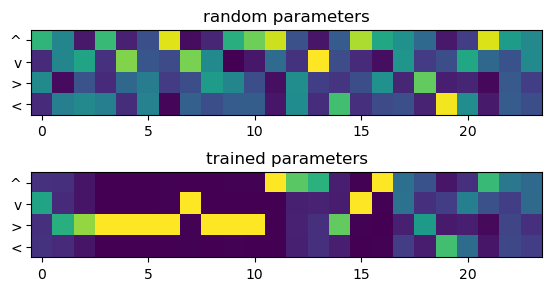

In [73]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
plt.subplot(2,1,1)
plt.title("random parameters")
plt.yticks(range(4), [*env.ACTION2CHAR.values()])
plt.imshow(jax.nn.softmax(params_init).T)
plt.subplot(2,1,2)
plt.title("trained parameters")
plt.yticks(range(4), [*env.ACTION2CHAR.values()])
plt.imshow(jax.nn.softmax(params).T)
plt.tight_layout();